<a href="https://colab.research.google.com/github/sinacipher/food-recommendation-suite/blob/main/Reorder_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Colab cache for faster access to the 'instacart-market-basket-analysis' dataset.
Dataset downloaded to: /kaggle/input/instacart-market-basket-analysis
Loading data...
Data loaded successfully!
Orders shape: (3421083, 7)
Products shape: (49688, 4)
Order products prior shape: (32434489, 4)
Order products train shape: (1384617, 4)
Preprocessing data...
Creating training set...
Feature names: ['up_orders', 'up_first_order', 'up_last_order', 'up_avg_cart_position', 'user_orders', 'user_period', 'user_avg_days_since_prior', 'user_total_products', 'user_reorder_ratio', 'prod_orders', 'prod_reorders', 'prod_first_orders', 'prod_second_orders', 'prod_avg_cart_position', 'prod_reorder_probability', 'prod_reorder_ratio']
Checking for infinite or large values...
Training model...
Model Evaluation:
Accuracy: 0.7694176684505566

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.78      0.86     56706
         1.0       0.26      0.71  

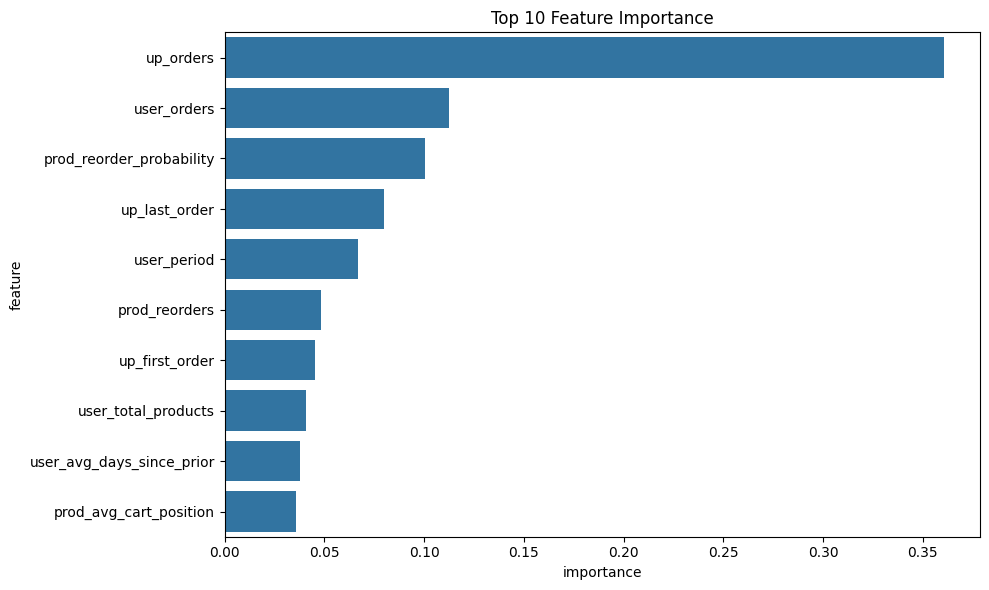


Example prediction for user_id 1:
    product_id  reorder_probability
0          196             0.921235
3        12427             0.895779
8        25133             0.884499
1        10258             0.882300
16       46149             0.808549
4        13032             0.781509
17       49235             0.727710
13       38928             0.659020
14       39657             0.602327
5        13176             0.596665

Model saved as 'reorder_prediction_model.pkl'
Scaler saved as 'scaler.pkl'
Feature names saved as 'feature_names.pkl'

Testing load function for user_id 2:
    product_id  reorder_probability
55       24852             0.881300
92       47209             0.868939
68       32792             0.846946
39       19156             0.805288
2         1559             0.800378
35       18523             0.788746
70       33754             0.779401
30       16589             0.767630
48       22124             0.721755
3         2002             0.707895


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
import zipfile
import warnings
warnings.filterwarnings('ignore')

# Download the dataset
print("Downloading dataset...")
path = kagglehub.dataset_download("psparks/instacart-market-basket-analysis")
print("Dataset downloaded to:", path)

# Extract files if needed
data_dir = "instacart_data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

    # Check if we need to extract files
    for file in os.listdir(path):
        if file.endswith('.zip'):
            with zipfile.ZipFile(os.path.join(path, file), 'r') as zip_ref:
                zip_ref.extractall(data_dir)

print("Loading data...")
# Load the datasets
try:
    orders = pd.read_csv(os.path.join(data_dir, 'orders.csv'))
    products = pd.read_csv(os.path.join(data_dir, 'products.csv'))
    order_products_prior = pd.read_csv(os.path.join(data_dir, 'order_products__prior.csv'))
    order_products_train = pd.read_csv(os.path.join(data_dir, 'order_products__train.csv'))
except FileNotFoundError:
    # Try loading from the original path if extraction didn't work
    orders = pd.read_csv(os.path.join(path, 'orders.csv'))
    products = pd.read_csv(os.path.join(path, 'products.csv'))
    order_products_prior = pd.read_csv(os.path.join(path, 'order_products__prior.csv'))
    order_products_train = pd.read_csv(os.path.join(path, 'order_products__train.csv'))
    data_dir = path

print("Data loaded successfully!")
print("Orders shape:", orders.shape)
print("Products shape:", products.shape)
print("Order products prior shape:", order_products_prior.shape)
print("Order products train shape:", order_products_train.shape)

# Data preprocessing
print("Preprocessing data...")

# Fill missing values
orders['days_since_prior_order'] = orders['days_since_prior_order'].fillna(0)

# Create user-product features
def create_user_product_features(orders_df, order_products_df):
    # Get prior orders
    user_product_stats = order_products_df.merge(orders_df[orders_df.eval_set == 'prior'], on='order_id')

    # Calculate user-product features
    user_product_features = user_product_stats.groupby(['user_id', 'product_id']).agg(
        up_orders=('order_id', 'count'),
        up_first_order=('order_number', 'min'),
        up_last_order=('order_number', 'max'),
        up_avg_cart_position=('add_to_cart_order', 'mean')
    ).reset_index()

    return user_product_features

# Create user features
def create_user_features(orders_df, order_products_df):
    # Get user statistics
    user_stats = orders_df[orders_df.eval_set == 'prior'].groupby('user_id').agg(
        user_orders=('order_number', 'max'),
        user_period=('days_since_prior_order', 'sum'),
        user_avg_days_since_prior=('days_since_prior_order', 'mean')
    ).reset_index()

    # Get user product statistics
    user_order_products = order_products_df.merge(orders_df[orders_df.eval_set == 'prior'], on='order_id')
    user_product_stats = user_order_products.groupby('user_id').agg(
        user_total_products=('product_id', 'count'),
        user_reorder_ratio=('reordered', 'mean')
    ).reset_index()

    # Merge user features
    user_features = user_stats.merge(user_product_stats, on='user_id')

    return user_features

# Create product features
def create_product_features(order_products_df):
    product_features = order_products_df.groupby('product_id').agg(
        prod_orders=('order_id', 'count'),
        prod_reorders=('reordered', 'sum'),
        prod_first_orders=('order_id', lambda x: (x == 1).sum()),
        prod_second_orders=('order_id', lambda x: (x == 2).sum()),
        prod_avg_cart_position=('add_to_cart_order', 'mean')
    ).reset_index()

    # Handle division by zero
    product_features['prod_reorder_probability'] = np.where(
        product_features.prod_orders > 0,
        product_features.prod_reorders / product_features.prod_orders,
        0
    )

    product_features['prod_reorder_ratio'] = np.where(
        product_features.prod_first_orders > 0,
        product_features.prod_reorders / product_features.prod_first_orders,
        0
    )

    return product_features.fillna(0)

# Create features
user_product_features = create_user_product_features(orders, order_products_prior)
user_features = create_user_features(orders, order_products_prior)
product_features = create_product_features(order_products_prior)

# Prepare training set
print("Creating training set...")
train_orders = orders[orders.eval_set == 'train']
train = train_orders.merge(user_features, on='user_id')

# Get the products that were actually ordered in the train set
train_products = order_products_train.merge(train_orders, on='order_id')[['user_id', 'product_id', 'reordered']]

# Create the full training set with all user-product combinations
# For efficiency, we'll sample a subset of users
sample_users = train.user_id.unique()[:5000]  # Use first 5k users for demonstration
train_sample = train[train.user_id.isin(sample_users)]

# Get all possible products for these users
user_products = user_product_features[user_product_features.user_id.isin(sample_users)]

# Merge with actual reorders
train_data = user_products.merge(
    train_products[['user_id', 'product_id', 'reordered']],
    on=['user_id', 'product_id'],
    how='left'
)
train_data['reordered'] = train_data['reordered'].fillna(0)

# Add user and product features
train_data = train_data.merge(user_features, on='user_id')
train_data = train_data.merge(product_features, on='product_id')

# Prepare features and target
X = train_data.drop(['user_id', 'product_id', 'reordered'], axis=1)
y = train_data['reordered']

# Store the feature names for later use
feature_names = X.columns.tolist()
print("Feature names:", feature_names)

# Check for infinite or very large values
print("Checking for infinite or large values...")
for col in X.columns:
    if X[col].dtype in ['float64', 'int64']:
        if np.isinf(X[col]).any():
            print(f"Column {col} has infinite values. Replacing with max/min...")
            max_val = X[col][~np.isinf(X[col])].max()
            min_val = X[col][~np.isinf(X[col])].min()
            X[col] = X[col].replace(np.inf, max_val)
            X[col] = X[col].replace(-np.inf, min_val)

        # Check for very large values
        if X[col].max() > 1e10:
            print(f"Column {col} has very large values. Scaling...")
            X[col] = X[col] / X[col].max()

# Fill any remaining NaN values
X = X.fillna(0)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
print("Training model...")
model = RandomForestClassifier(
    n_estimators=30,
    random_state=42,
    n_jobs=-1,
    max_depth=10,
    class_weight='balanced'
)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
print("Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Feature Importance:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

# Function to predict reorders for a user
def predict_reorders(user_id, model, scaler, user_features, product_features, user_product_features, feature_names, top_n=10):
    # Get user data
    user_data = user_features[user_features.user_id == user_id]

    # Get all products the user has ordered before
    user_products = user_product_features[user_product_features.user_id == user_id]

    if len(user_products) == 0:
        return []

    # Merge with product features
    user_products = user_products.merge(product_features, on='product_id')

    # Add user features to each row
    for col in user_data.columns:
        if col != 'user_id':
            user_products[col] = user_data[col].values[0]

    # Prepare features for prediction - ensure same order as training
    X_user = user_products[feature_names].copy()

    # Handle infinite values
    for col in X_user.columns:
        if X_user[col].dtype in ['float64', 'int64']:
            if np.isinf(X_user[col]).any():
                max_val = X_user[col][~np.isinf(X_user[col])].max()
                min_val = X_user[col][~np.isinf(X_user[col])].min()
                X_user[col] = X_user[col].replace(np.inf, max_val)
                X_user[col] = X_user[col].replace(-np.inf, min_val)

    X_user = X_user.fillna(0)
    X_user_scaled = scaler.transform(X_user)

    # Predict probabilities
    probabilities = model.predict_proba(X_user_scaled)[:, 1]

    # Add probabilities to products
    user_products['reorder_probability'] = probabilities

    # Get top N products
    top_products = user_products.sort_values('reorder_probability', ascending=False).head(top_n)

    return top_products[['product_id', 'reorder_probability']]

# Example prediction for a user
print("\nExample prediction for user_id 1:")
user_id_example = 1
top_reorders = predict_reorders(user_id_example, model, scaler, user_features, product_features,
                               user_product_features, feature_names)
print(top_reorders)

# Save the model, scaler, and feature names
import joblib
joblib.dump(model, 'reorder_prediction_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(feature_names, 'feature_names.pkl')
print("\nModel saved as 'reorder_prediction_model.pkl'")
print("Scaler saved as 'scaler.pkl'")
print("Feature names saved as 'feature_names.pkl'")

# Function to load and use the model for new predictions
def load_and_predict(user_id, user_features, product_features, user_product_features):
    # Load the model, scaler, and feature names
    model = joblib.load('reorder_prediction_model.pkl')
    scaler = joblib.load('scaler.pkl')
    feature_names = joblib.load('feature_names.pkl')

    return predict_reorders(user_id, model, scaler, user_features, product_features,
                           user_product_features, feature_names)

# Example of using the load function
print("\nTesting load function for user_id 2:")
user_id_example = 2
top_reorders = load_and_predict(user_id_example, user_features, product_features, user_product_features)
print(top_reorders)